## House Prices - Advanced Regression Techniques

****** HERE WILL BE ID *******

### TL;DR

### Part 1 Imports and Definitions


In [76]:
# import numpy, matplotlib, etc. 
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sw
import os
from tqdm import tqdm


# sklearn imports
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neural_network
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


- define the input and output folders


In [77]:
input_folder = "input/"

train_data_path = os.path.join(input_folder, "train.csv")
test_data_path = os.path.join(input_folder, "test.csv")

  - define the show graphs variable


In [78]:
SHOW_GRAPHS = False

#### Load the traning data
  - Load the csv data to variables


In [79]:
train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)

# display the first few rows of the data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Part 2 Data Investigation EDA


#### Data Cleaning

- Remove the id column


In [80]:
# Drop the "Id" column from the train_data DataFrame
train_data_id = train_data["Id"]
train_data = train_data.drop("Id", axis=1)

# Drop the "Id" column from the test_data DataFrame
test_id = test_data["Id"]
test_data = test_data.drop("Id", axis=1)


train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


- Count the number of feuatures

In [81]:
print(f"Number of features: {train_data.shape[1]}")

Number of features: 80


Get summary statistics for the training dataset show only the numerical columns


In [82]:
train_data.describe()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


- Get the data types of the columns in the training dataset


In [83]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

None

We can see that most of the data is object

- Check for missing values

In [84]:
def show_missing_data_with_percentage(data):
    print("Missing values in the dataset:")
    print("-----------------------------------------")
    print("Total Rows: ", len(data))
    print("_________________________________________")
    # Display missing values in each column of the training dataset
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(train_data)) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
    missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)
    print(missing_data.head(20))
    
    print("\n\nTotal missing values: ", missing_data['Missing Values'].sum())
    
    


In [85]:
# Display missing values in the training dataset
show_missing_data_with_percentage(train_data)

Missing values in the dataset:
-----------------------------------------
Total Rows:  1460
_________________________________________
              Missing Values  Percentage
PoolQC                  1453   99.520548
MiscFeature             1406   96.301370
Alley                   1369   93.767123
Fence                   1179   80.753425
MasVnrType               872   59.726027
FireplaceQu              690   47.260274
LotFrontage              259   17.739726
GarageYrBlt               81    5.547945
GarageCond                81    5.547945
GarageType                81    5.547945
GarageFinish              81    5.547945
GarageQual                81    5.547945
BsmtExposure              38    2.602740
BsmtFinType2              38    2.602740
BsmtCond                  37    2.534247
BsmtQual                  37    2.534247
BsmtFinType1              37    2.534247
MasVnrArea                 8    0.547945
Electrical                 1    0.068493
MSSubClass                 0    0.000000


Tota

We can see that the columns "Alley", "PoolQC", "Fence", "MiscFeature" have a lot of missing values.

- Handle the missing data<br><br>
First step to remove highly missing features (by threshold)

In [86]:
def drop_highly_missing_features(data, fetures_to_drop):
    data = data.drop(fetures_to_drop, axis=1)
    return data


def find_features_with_missing_values_threshold(data, threshold):
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(train_data)) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
    missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)
    features_to_drop = missing_data[missing_data['Percentage'] > threshold].index
    return features_to_drop


In [87]:
# Set the threshold for missing values to remove
threshold = 80
# for 80 it return # ["Alley", "PoolQC", "Fence", "MiscFeature"]
drop_features = find_features_with_missing_values_threshold(train_data, threshold) 


train_data = drop_highly_missing_features(train_data, drop_features)

test_data = drop_highly_missing_features(test_data, drop_features)

print("Remove this features: ", drop_features)

Remove this features:  Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')


In [88]:
show_missing_data_with_percentage(train_data)

Missing values in the dataset:
-----------------------------------------
Total Rows:  1460
_________________________________________
              Missing Values  Percentage
MasVnrType               872   59.726027
FireplaceQu              690   47.260274
LotFrontage              259   17.739726
GarageType                81    5.547945
GarageYrBlt               81    5.547945
GarageFinish              81    5.547945
GarageQual                81    5.547945
GarageCond                81    5.547945
BsmtExposure              38    2.602740
BsmtFinType2              38    2.602740
BsmtQual                  37    2.534247
BsmtCond                  37    2.534247
BsmtFinType1              37    2.534247
MasVnrArea                 8    0.547945
Electrical                 1    0.068493
Fireplaces                 0    0.000000
KitchenQual                0    0.000000
KitchenAbvGr               0    0.000000
BedroomAbvGr               0    0.000000
HalfBath                   0    0.000000


Tota

Handling Missing Values for Numerical Features

In [89]:
# fill missing numerical values with median
def handle_missing_values_numerical(data):
    for column in data.select_dtypes(include=[np.number]).columns:
        data[column].fillna(data[column].median(), inplace=True)
    return data

Handling Missing Values for Categorical Features

In [90]:
# Fill missing categorical values with most frequent value
def handle_missing_values_categorical(data):
    for column in data.select_dtypes(include=[object]).columns:
        data[column].fillna(data[column].mode()[0], inplace=True)
    return data

One function to handle the missing values

In [91]:
def handle_missing_values(data):
    data = handle_missing_values_numerical(data)
    data = handle_missing_values_categorical(data)
    return data

In [92]:
# fill the missing values in the train data
train_data = handle_missing_values(train_data)

# fill the missing values in the test data
test_data = handle_missing_values(test_data)

Verify No More Missing Values

In [93]:
print("\nMissing values in the training dataset after filling:")
print(train_data.isnull().sum().sum())

print("\nMissing values in the test dataset after filling:")
print(test_data.isnull().sum().sum())



Missing values in the training dataset after filling:
0

Missing values in the test dataset after filling:
0


In [94]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


Convert Categorical Features to Numeric Using One-Hot Encoding

In [95]:
print("Data types in training data:")
print(train_data.dtypes)


Data types in training data:
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 76, dtype: object


#### Feature Analysis & Visualization 

Distribution of SalePrice

In [96]:
if SHOW_GRAPHS:
    plt.figure(figsize=(11, 7))
    sns.histplot(train_data['SalePrice'], kde=True, bins=30, color='blue')
    plt.title('Distribution of SalePrice')
    plt.xlabel('SalePrice')
    plt.ylabel('Count')
    plt.show()
    

Normal Probability

In [97]:
from scipy import stats

if SHOW_GRAPHS:
    plt.figure(figsize=(10, 6))
    stats.probplot(train_data['SalePrice'], dist="norm", plot=plt)
    plt.title('Normal Probability Plot of SalePrice')
    plt.show()

Histogram for SalePrice

In [98]:
if SHOW_GRAPHS:
    fig = px.histogram(train_data, x='SalePrice', title='Distribution of SalePrice')
    fig.show()

We can see the distribution of SalePrice

- Box plot for SalePrice

In [99]:
if SHOW_GRAPHS:
    fig = px.box(train_data, y='SalePrice', title='Boxplot of SalePrice')
    fig.show()

OverallQual: Rates the overall material and finish of the house

In [100]:

if SHOW_GRAPHS:
    overall_qual_mean = train_data.groupby('OverallQual')['SalePrice'].mean()
    fig = px.bar(overall_qual_mean, x=overall_qual_mean.index, y='SalePrice', title='OverallQual vs SalePrice')
    fig.add_trace(go.Scatter(x=overall_qual_mean.index, y=overall_qual_mean.values, mode='lines', name='lines'))
    fig.show()


We calculate the correlation of each feature with SalePrice and sort them to identify the strongest relationships.
- To do so we must encode the categorical columns

In [101]:

# Split the data to numerical and categorical columns
numerical_columns = train_data.select_dtypes(include=["int64", 'float64']).columns
categorical_columns = train_data.select_dtypes(include=["object"]).columns


# Encode the categorical columns
categorical_columns_encoded = pd.get_dummies(train_data[categorical_columns])

# Combine the numerical and encoded categorical columns
train_data_encoded = pd.concat([train_data[numerical_columns], categorical_columns_encoded], axis=1)


# Create a correlation matrix
correlation_matrix = train_data_encoded.corr().abs()


- Change N to the number of top features you want to analyze 

In [102]:
N = 20

# Get the top N correlated features with the target variable
top_correlated_features = correlation_matrix['SalePrice'].sort_values(ascending=False).head(N).index.tolist()

# Filter the correlation matrix to get the top N correlated features
filtered_correlation_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

Top correlation with SalePrice

In [103]:
print(f"Top {N} features with the highest correlation with SalePrice:")
print(filtered_correlation_matrix['SalePrice'])

Top 20 features with the highest correlation with SalePrice:
SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
ExterQual_TA        0.589044
FullBath            0.560664
BsmtQual_Ex         0.553105
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
KitchenQual_TA      0.519298
GarageFinish_Unf    0.513906
YearRemodAdd        0.507101
KitchenQual_Ex      0.504094
BsmtQual_TA         0.498545
Foundation_PConc    0.497734
MasVnrArea          0.472614
Fireplaces          0.466929
Name: SalePrice, dtype: float64


Pairplot Visualizing Correlation

In [104]:
if SHOW_GRAPHS:
    sns.pairplot(train_data[top_correlated_features[:5]], height=3.5)

Heatmap for correlation matrix


In [105]:
import plotly.graph_objects as go

def show_top_correlated_features(correlation_matrix, n):
    # Display the heatmap of the correlation matrix with numbers in each cell
    fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='Viridis',
        text=correlation_matrix.values.round(2),  # Round values for display
        texttemplate="%{text}",
        showscale=True))
    fig.update_layout(title=f"Top {n} Correlated Features", width=1000, height=800)
    fig.show()

In [106]:
if SHOW_GRAPHS:
    show_top_correlated_features(filtered_correlation_matrix, N)

#### Data Standardization & Outliers 

Descriptive statistics

In [107]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Standardize the data

In [108]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler

# # Standardizing data
# saleprice_scaled = StandardScaler().fit_transform(np.array(train_data['SalePrice']).reshape(-1, 1));
# low_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][:10]
# high_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][-10:]

# # Display the low and high range of the SalePrice after standardization
# print('\nOuter range (low) of the distribution:')
# print(low_range)
# print("\n----------------------------------------")
# print('\nOuter range (high) of the distribution:')
# print(high_range)

Find and remove outliers

- Function to find the outliers

In [109]:
# import plotly.graph_objects as go

# def show_outliers(data, target, compare):
#     # Create a scatter plot for data points
#     fig = go.Figure(data=go.Scatter(
#         x=data[compare],
#         y=data[target],
#         mode='markers',
#         text=data.index,  # Assuming the index is the ID you want to show on hover
#         hoverinfo='text+x+y',  # Show ID, x (compare), and y (target) values on hover
#         marker=dict(color='blue', size=10, line=dict(width=1, color='DarkSlateGrey')),
#         name='Data Points'
#     ))
    
#     # Identify outliers (this is an example, adjust according to your criteria)
#     outliers = data[data[compare] > data[compare].quantile(0.99)]  # Top 1% as outliers
    
#     # Add outliers to the plot with a different color
#     fig.add_trace(go.Scatter(
#         x=outliers[compare],
#         y=outliers[target],
#         mode='markers',
#         text=outliers.index,  # Assuming the index is the ID you want to show on hover
#         hoverinfo='text+x+y',  # Show ID, x (compare), and y (target) values on hover
#         marker=dict(color='red', size=12, line=dict(width=1, color='DarkSlateGrey')),
#         name='Outliers'
#     ))
    
#     # Update plot layout
#     fig.update_layout(title=f'{target} vs {compare}',
#                       xaxis_title=compare,
#                       yaxis_title=target,
#                       hovermode='closest')
    
#     fig.show()

In [110]:
# # remove outliers by index
# def remove_outliers_by_index(data, index):
#     try:
#         if isinstance(index, list):
#             for i in index:
#                 data = data.drop(i)
#         else:
#             data = data.drop(index)
#     except KeyError:
#         print("Index not found")
#     return data

- GrLivArea: Above grade (ground) living area square feet

In [111]:
# # show the SalePrice vs GrLivArea, and the id of the outliers
# if SHOW_GRAPHS:
#     show_outliers(train_data, 'SalePrice', 'GrLivArea')

In [112]:
# # Remove the outliers points
# index_list = [523, 1298]
# train_data = remove_outliers_by_index(train_data, index_list)
# show_outliers(train_data, 'SalePrice', 'GrLivArea')

- TotalBsmtSF: Total square feet of basement area

In [113]:
# if SHOW_GRAPHS:
#     show_outliers(train_data, 'SalePrice', 'TotalBsmtSF')

In [114]:
# # remove the outliers points
# index_list = [440, 496, 332]
# train_data = remove_outliers_by_index(train_data, index_list)

# show_outliers(train_data, 'SalePrice', 'TotalBsmtSF')

Histogram probability plot

In [115]:
# import seaborn as sns
# from scipy.stats import norm

# def show_probability_plot(data, target):
#     # Create the Histogram
#        # Show Histogram with a normal distribution fit line
#     sns.histplot(train_data[target], kde=True, color="blue", stat="density")
#     # Overlay the normal distribution fit
#     mean, std = norm.fit(train_data[target])
#     xmin, xmax = plt.xlim()
#     x = np.linspace(xmin, xmax, 100)
#     p = norm.pdf(x, mean, std)
#     plt.plot(x, p, 'k', linewidth=2)
#     title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std)
#     plt.title(title)
    
#     # Normal probability plot
#     fig = plt.figure(figsize=(10, 6))
#     ax = fig.add_subplot(111)
#     stats.probplot(train_data[target], dist="norm", plot=ax)  # Use actual data for the plot
#     ax.set_title('Normal Probability Plot of {}'.format(target))
#     plt.show()
    

In [116]:
# if SHOW_GRAPHS:
#     show_probability_plot(train_data, 'SalePrice')

SalePrice is right skewed, so we need to transform it to be normally distributed


In [117]:
# # Log transformation of the target variable
# train_data['SalePrice'] = np.log(train_data['SalePrice'])

# if SHOW_GRAPHS:
#     show_probability_plot(train_data, 'SalePrice')

We will check GrLivArea

In [118]:
# # Show histogram and probability plot for GrLivArea
# if SHOW_GRAPHS:
#     show_probability_plot(train_data, 'GrLivArea')

GrLivArea is right skewed, so we need to transform it to be normally distributed


In [119]:
# # Log transformation of GrLivArea
# train_data['GrLivArea'] = np.log(train_data['GrLivArea'])

# if SHOW_GRAPHS:
#     show_probability_plot(train_data, 'GrLivArea')

#### Feature Engineering

Total Square Footage
- We create a new feature TotalSF by summing up the total basement square footage, first floor square footage, second floor square footage, and garage area. This feature represents the total square footage of the house.

In [120]:
features_engineering_list = []

# create TotalSF feature
def create_TotalSF_feature(data, features_engineering_list=None):
    data['TotalSqureF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GarageArea']
    if features_engineering_list is not None:
        features_engineering_list.append('TotalSqureF')
    return data

# Create the TotalSF feature for the train and test data
train_data = create_TotalSF_feature(train_data, features_engineering_list)

test_data = create_TotalSF_feature(test_data)

Age of the House
- We calculate the age of the house at the time of sale by subtracting the year the house was built from the year it was sold.

In [121]:
# create age_of_house feature
def create_age_of_house_feature(data, features_engineering_list=None):
    data['AgeOfHouse'] = data['YrSold'] - data['YearBuilt']
    if features_engineering_list is not None:
        features_engineering_list.append('AgeOfHouse')
    return data


# Create the AgeOfHouse feature for the train and test data
train_data = create_age_of_house_feature(train_data, features_engineering_list)

test_data = create_age_of_house_feature(test_data)

Age of the Renovation
- We calculate the age of the house since its most recent renovation by subtracting the year of the most recent renovation from the year it was sold.

In [122]:
# create age_of_renovation feature
def create_age_of_renovation_feature(data, features_engineering_list=None):
    data['AgeOfRenovation'] = data['YrSold'] - data['YearRemodAdd']
    if features_engineering_list is not None:
        features_engineering_list.append('AgeOfRenovation')
    return data

# Create the AgeOfRenovation feature for the train and test data
train_data = create_age_of_renovation_feature(train_data, features_engineering_list)

test_data = create_age_of_renovation_feature(test_data)

Total Bathrooms
- We create a new feature TotalBath by summing up the number of full and half bathrooms in the basement and above grade, with half bathrooms counted as 0.5.

In [123]:
# create TotalBath feature
def create_TotalBath_feature(data, features_engineering_list=None):
    data['TotalBath'] = data['FullBath'] + 0.5 * data['HalfBath'] + data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath']
    if features_engineering_list is not None:
        features_engineering_list.append('TotalBath')
    return data

# Create the TotalBath feature for the train and test data
train_data = create_TotalBath_feature(train_data, features_engineering_list)

test_data = create_TotalBath_feature(test_data)

Total Porch Area
- We create a new feature TotalPorchSF by summing up the area of all porch-related features, representing the total porch area of the house.

In [124]:
# create TotalPorchSF feature
def create_TotalPorchSF_feature(data, features_engineering_list=None):
    data['TotalPorchSF'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
    if features_engineering_list is not None:
        features_engineering_list.append('TotalPorchSF')
    return data

# Create the TotalPorchSF feature for the train and test data
train_data = create_TotalPorchSF_feature(train_data, features_engineering_list)

test_data = create_TotalPorchSF_feature(test_data)

Display the New Features

In [125]:
print(train_data[features_engineering_list].head())


   TotalSqureF  AgeOfHouse  AgeOfRenovation  TotalBath  TotalPorchSF
0         3114           5                5        3.5            61
1         2984          31               31        2.5             0
2         3314           7                6        3.5            42
3         3115          91               36        2.0           307
4         4179           8                8        3.5            84


In [126]:
if SHOW_GRAPHS:
    # Split the data to numerical and categorical columns
    numerical_columns = train_data.select_dtypes(include=["int64", 'float64']).columns
    categorical_columns = train_data.select_dtypes(include=["object"]).columns


    # Encode the categorical columns
    categorical_columns_encoded = pd.get_dummies(train_data[categorical_columns])

    # Combine the numerical and encoded categorical columns
    train_data_encoded = pd.concat([train_data[numerical_columns], categorical_columns_encoded], axis=1)


    # Create a correlation matrix
    correlation_matrix = train_data_encoded.corr().abs()
    
    # Get the top N correlated features with the target variable
    top_correlated_features = correlation_matrix['SalePrice'].sort_values(ascending=False).head(N).index.tolist()

    # Filter the correlation matrix to get the top N correlated features
    filtered_correlation_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]
    
    show_top_correlated_features(filtered_correlation_matrix, N)
    
    

### Part 3 Regression Models & Cross Validation

#### Pre model Setup

- Split the data into features and target variable (x,y)

- Encode categorical variables

In [127]:
def encode_obj(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    
    enc = OrdinalEncoder(dtype=np.int64).set_params(encoded_missing_value=-1)
    autoscaler = StandardScaler()
    
    enc = enc.fit_transform(df[cat_cols])
    enc = pd.DataFrame(enc, columns=cat_cols)
    
    return pd.concat([df[num_cols.tolist()], enc[cat_cols.tolist()]], axis=1)  


In [128]:

train_data = encode_obj(train_data)
print(train_data.shape)

print("missing Values in the training dataset after encoding:")
print(train_data.isnull().sum().sum())

#fill the missing values
train_data = handle_missing_values(train_data)
df_train = train_data.copy()




(1460, 81)
missing Values in the training dataset after encoding:
0


In [129]:
# split the data into features and target variable
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']

- Split the data

In [130]:
test_size = 0.3

In [131]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

- Define a function for computing RMSE


In [132]:
from sklearn.model_selection import cross_val_score


def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return rmse.mean()

#### Regression models

We will implementing different regression models<br> evaluating them using Cross Validation, and computing the RMSE

**Define Pipelines for Each Model**

-  Linear Regression

In [133]:
# # Linear Regression
# lin_reg_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lin_reg', LinearRegression())
# ])

# lin_reg_rmse = rmse_cv(lin_reg_pipeline)
# print(f"Linear Regression RMSE: {lin_reg_rmse}")

# # Fit the model and predict
# lin_reg_pipeline.fit(X_train, y_train)
# y_pred = lin_reg_pipeline.predict(X_val)
# lin_reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Linear Regression Validation RMSE: {lin_reg_val_rmse}")
# lin_reg_pipeline


- SGD Regressor

In [134]:
# # SGD Regressor
# sgd_reg_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('sgd_reg', SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
# ])

# sgd_reg_rmse = rmse_cv(sgd_reg_pipeline)
# print(f"SGD Regressor RMSE: {sgd_reg_rmse}")

# # Fit the model and predict
# sgd_reg_pipeline.fit(X_train, y_train)
# y_pred = sgd_reg_pipeline.predict(X_val)
# sgd_reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"SGD Regressor Validation RMSE: {sgd_reg_val_rmse}")
# sgd_reg_pipeline

- Ridge Regression

In [135]:
# # Ridge Regression
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import GridSearchCV


# ridge_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('ridge', Ridge())
# ])

# # Define the hyperparameters grid
# ridge_param_grid = {
#     'ridge__alpha': [0.1, 1.0, 10.0, 100.0]
# }

# ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
# ridge_grid_search.fit(X_train, y_train)

# best_ridge = ridge_grid_search.best_estimator_
# best_ridge_rmse = np.sqrt(-ridge_grid_search.best_score_)
# print(f"Best Ridge model: {best_ridge}")
# print(f"Best Ridge RMSE: {best_ridge_rmse}")

# # Fit the best model and predict
# best_ridge.fit(X_train, y_train)
# y_pred = best_ridge.predict(X_val)
# ridge_reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Ridge Regression Validation RMSE: {ridge_reg_val_rmse}")
# ridge_pipeline


- Lasso Regression

In [136]:
# # Lasso Regression
# from sklearn.linear_model import Lasso


# lasso_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lasso', Lasso())
# ])

# lasso_param_grid = {
#     'lasso__alpha': [0.01, 0.1, 1.0, 10.0],
#     'lasso__max_iter': [1000, 5000, 10000]
# }

# lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
# lasso_grid_search.fit(X_train, y_train)

# best_lasso = lasso_grid_search.best_estimator_
# best_lasso_rmse = np.sqrt(-lasso_grid_search.best_score_)
# print(f"Best Lasso model: {best_lasso}")
# print(f"Best Lasso RMSE: {best_lasso_rmse}")

# # Fit the best model and predict
# best_lasso.fit(X_train, y_train)
# y_pred = best_lasso.predict(X_val)
# lasso_reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Lasso Regression Validation RMSE: {lasso_reg_val_rmse}")
# lasso_pipeline

- Elastic Net Regression

In [137]:
# # Elastic Net Regression
# from sklearn.linear_model import ElasticNet


# elastic_net_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('elastic_net', ElasticNet())
# ])

# elastic_net_param_grid = {
#     'elastic_net__alpha': [0.01, 0.1, 1.0],
#     'elastic_net__l1_ratio': [0.1, 0.5, 0.9],
#     'elastic_net__max_iter': [1000, 5000, 10000]
# }

# elastic_net_grid_search = GridSearchCV(elastic_net_pipeline, elastic_net_param_grid, cv=5, scoring='neg_mean_squared_error')
# elastic_net_grid_search.fit(X_train, y_train)

# best_elastic_net = elastic_net_grid_search.best_estimator_
# best_elastic_net_rmse = np.sqrt(-elastic_net_grid_search.best_score_)
# print(f"Best Elastic Net model: {best_elastic_net}")
# print(f"Best Elastic Net RMSE: {best_elastic_net_rmse}")

# # Fit the best model and predict
# best_elastic_net.fit(X_train, y_train)
# y_pred = best_elastic_net.predict(X_val)
# elastic_net_val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Elastic Net Regression Validation RMSE: {elastic_net_val_rmse}")
# elastic_net_pipeline


In [138]:
# # Display bar plot for the best 3 models
# if SHOW_GRAPHS:
#     fig = go.Figure(data=[
#         go.Bar(name='Ridge', x=['Ridge'], y=[best_ridge_rmse], text=[best_ridge_rmse], textposition='auto'),
#         go.Bar(name='Lasso', x=['Lasso'], y=[best_lasso_rmse], text=[best_lasso_rmse], textposition='auto'),
#         go.Bar(name='Elastic Net', x=['Elastic Net'], y=[best_elastic_net_rmse], text=[best_elastic_net_rmse], textposition='auto')
#     ])
    
#     fig.update_layout(title='Best RMSE for Ridge, Lasso, and Elastic Net',
#                       xaxis_title='Model',
#                       yaxis_title='RMSE')
    
#     fig.show()

#### Feature Selection

- Recursive Feature Elimination (RFE) for All Models

In [139]:
# # Define a function to perform RFE
# from sklearn.feature_selection import RFE

# def rfe_feature_selection(model, num_features):
#     rfe = RFE(model, n_features_to_select=num_features)
#     rfe.fit(X_train, y_train)
#     selected_features = [feature for feature, selected in zip(X.columns, rfe.support_) if selected]
#     return selected_features

- Perform RFE with Linear Regression

In [140]:
# # 
# selected_features = rfe_feature_selection(LinearRegression(), 20)
# print(f"Selected features: {selected_features}")

# # Re-train Linear Regression with selected features
# X_train_selected = X_train[selected_features]
# X_val_selected = X_val[selected_features]
# X_test_selected = X_test[selected_features]

# # Pipeline with selected features
# selected_features_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lin_reg', LinearRegression())
# ])

# selected_features_pipeline.fit(X_train_selected, y_train)
# y_pred = selected_features_pipeline.predict(X_val_selected)
# selected_features_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Linear Regression with Selected Features RMSE: {selected_features_rmse}")
# selected_features_pipeline

#### Model Evaluation

Compare Model Performance After RFE

In [141]:
# models = {
#     'Ridge Regression': best_ridge,
#     'Lasso Regression': best_lasso,
#     'Elastic Net Regression': best_elastic_net
# }

# # Fit models and calculate validation RMSE
# results = {}
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     results[name] = rmse
#     print(f"{name} Validation RMSE: {rmse}")
    
    

# # set the best model name
# best_model_name = min(results, key=results.get)
# print("-----------------------------")
# print(f"Best Model: {best_model_name}")
# print(f"Validation RMSE: {results[best_model_name]}")
# best_model = models[best_model_name]
    
# # Plot model performance
# plt.figure(figsize=(12, 8))
# plt.bar(results.keys(), results.values())
# plt.ylabel('RMSE')
# plt.title('Model Comparison')
# plt.show()




In [149]:
from sklearn.feature_selection import RFE


def featureSelection(model, train, target, val_data, val_target):
    ref_select = RFE(model, n_features_to_select=len(df_train.columns)).fit(train, target)
    ref_score = ref_select.score(val_data, val_target)
    
    for n in range(1, len(df_train.columns)):
        ref = RFE(model, n_features_to_select=3).fit(train, target)
        ref_score_test = ref.score(val_data, val_target)

        if ref_score_test > ref_score:
            ref_score = ref_score_test
            ref_select = ref
            
    return ref_select

In [150]:
from sklearn.model_selection import KFold


def splitDataToKFold(X, t, k):
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    result = []
    
    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        X_train = X.loc[train_ids]
        t_train = t.loc[train_ids]
        X_val = X.loc[val_ids]
        t_val = t.loc[val_ids]
        
        result.append({"X_train": X_train
                      ,"t_train" : t_train
                      ,"X_val": X_val
                      ,"t_val": t_val
                      })
    return result
    
def margeCV(cv):
    X_train = []
    t_train = []    
    X_val = []
    t_val = []
    
    for i, d in enumerate(cv):
            X_train.append(d["X_train"])
            t_train.append(d["t_train"])
            
            X_val.append(d["X_val"])
            t_val.append(d["t_val"])
            
    X_train = pd.concat(X_train) 
    t_train = pd.concat(t_train) 
    X_val = pd.concat(X_val) 
    t_val = pd.concat(t_val) 
    
    return {"X_train": X_train,
            "t_train": t_train,
            "X_val": X_val,
            "t_val": t_val
            }

In [151]:


# split to train and validation


from sklearn.linear_model import Lasso


cv = splitDataToKFold(X, y, k=5)
cv = margeCV(cv)

# use lasso model
model = Lasso(alpha=0.1)
print("Done with lasso")
# feature selection
# model = featureSelection(model, cv["X_train"], cv["t_train"], cv['X_val'], cv['t_val'])
print("Done with FS")

model.fit(cv["X_train"],cv["t_train"])
print("Done with fit")

print(f"Train Score: {model.score(cv['X_train'], cv['t_train'])}\n\
Validation Score: {model.score(cv['X_val'], cv['t_val'])}")

best_model = model

Done with lasso
Done with FS


Done with fit
Train Score: 0.849148945971236
Validation Score: 0.849148945971236


d:\softwere\One Drive\OneDrive - Afeka College Of Engineering\Machine Learning\House Prices\house-prices_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e+12, tolerance: 3.683e+09



### Part 4 Export Model

- Run the model on test data

In [152]:
X_test = test_data
X_test = encode_obj(X_test)
X_test = handle_missing_values(X_test)

predictions = best_model.predict(X_test)

- Create sumbission file for the test data

In [153]:
submission_df = pd.DataFrame({'Id': test_id, 'SalePrice': predictions})
submission_df.to_csv('submission.csv', index=False)


# print the time of the submission
time = pd.Timestamp.now()
formatted_time = time.strftime('%H:%M:%S')
print(f"Your submission was successfully saved at time {formatted_time}")


Your submission was successfully saved at time 16:45:36


## DELETE IN THE END!!!!!!!!!!!!!!!!!!!

Root Mean Squared Error (RMSE) between submission and real result (log scale): 0.1705


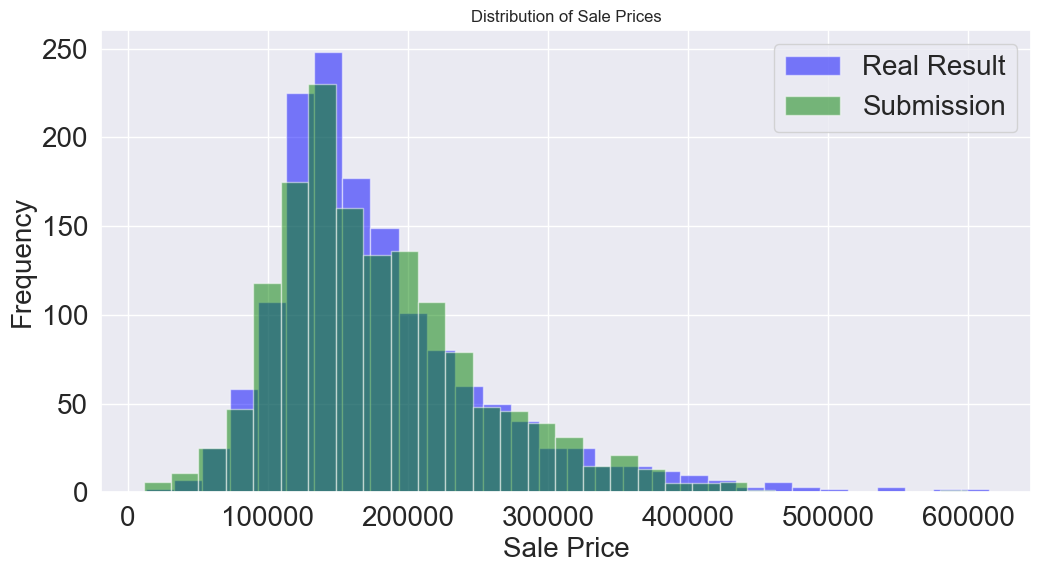

In [154]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Load real result and submission
real_result = pd.read_csv("compare/RESULT_FROM_WEB_REMOVE.csv")
submission_test = pd.read_csv('submission.csv')

# Merge DataFrames on 'Id' column
merged_df = pd.merge(submission_test, real_result, on='Id', suffixes=('_pred', '_real'))

# Calculate RMSE based on logarithm of values
rmse = np.sqrt(mean_squared_error(np.log(merged_df['SalePrice_real']), np.log(merged_df['SalePrice_pred'])))

print(f"Root Mean Squared Error (RMSE) between submission and real result (log scale): {rmse:.4f}")


# Plotting
plt.figure(figsize=(12, 6))

# Plot histogram for real_result
plt.hist(real_result['SalePrice'], bins=30, alpha=0.5, label='Real Result', color='blue')

# Plot histogram for submission_df
plt.hist(submission_test['SalePrice'], bins=30, alpha=0.5, label='Submission', color='green')

# Adding labels and title
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()